<a href="https://colab.research.google.com/github/Mansouraran/AI-projects/blob/main/variational_autoencoders_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

This is based on [Geron's notebook, chapter 17](https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb), in accordance with Apache License v2

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

Load the data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

This introduces Gaussian noise with `z_mean` and `z_log_var`

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    Input:
      z_mean - mean vector
      z_log_var - log variance vector, which is the log of the square of the standard deviation
    Output: z
    """
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

In [ ]:
# the size of the latent space
codings_size = 10

#### Setting the Encoder

In [ ]:
inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z) # log(σ^2)
codings = Sampling()([codings_mean, codings_log_var])

In [ ]:
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 150)          117750      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          15100       ['dense[0][0]']                  
                                                                                              

#### Setting the Decoder

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)

In [ ]:
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
variational_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               1100      
                                                                 
 dense_5 (Dense)             (None, 150)               15150     
                                                                 
 dense_6 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 134,634
Trainable params: 134,634
Non-trainable params: 0
_________________________________________________________________


#### Setting the Variational Autoencoder

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

In [ ]:
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
variational_ae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 model (Functional)          [(None, 10),              134870    
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 model_1 (Functional)        (None, 28, 28)            134634    
                                                                 
Total params: 269,504
Trainable params: 269,504
Non-trainable params: 0
_________________________________________________________________


#### Setting the latent loss function

The latent loss that pushes the autoencoder to have codings that look as though they were sampled from a simple
Gaussian distribution: it is the KL divergence between the target distribution (i.e.,
the Gaussian distribution) and the actual distribution of the coding.

It computes the latent loss for each instance in the batch, summing over the last axis. Then we compute the mean loss over all the instances in the batch, and we divide the result by 784 to ensure it has the appropriate scale compared to the reconstruction loss.

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

#### Setting the Optimizer

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")

#### Training

In [ ]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25


430/430 [==============================] - 4s 5ms/step - loss: 0.0502 - val_loss: 0.0382
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0360 - val_loss: 0.0353
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.0344 - val_loss: 0.0343
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0336 - val_loss: 0.0335
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0331 - val_loss: 0.0333
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0327 - val_loss: 0.0329
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0324 - val_loss: 0.0326
Epoch 8/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0321 - val_loss: 0.0326
Epoch 9/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0320 - val_loss: 0.0325
Epoch 10/25
430/430 [==============================] - 2s 4ms/step - loss: 0.0318 - val_loss: 0.0320
Epoch 11/2

#### Plot Reconstructions

In [ ]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 119ms/step


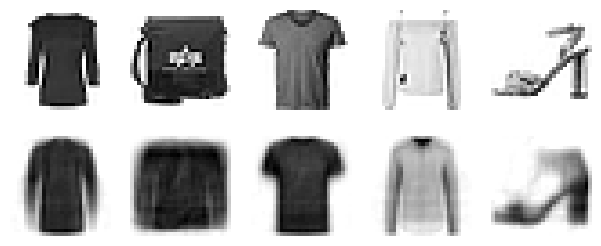

In [ ]:
plot_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

Let's generate a few random codings, and decode them:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

Now let's plot these images:

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

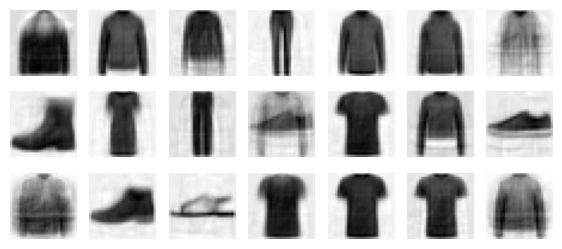

In [ ]:
plot_multiple_images(images, 7)
plt.show()

Now let's perform semantic interpolation between 2 images:

In [ ]:
tf.random.set_seed(42)

In [ ]:
codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case

In [ ]:
codings

array([[ 0.        ,  0.        ,  0.        , -0.8       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.53333333,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.26666667,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.26666667,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.53333333,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.8       ,  0.        ,
         0.        ,  0.        ,  0.        

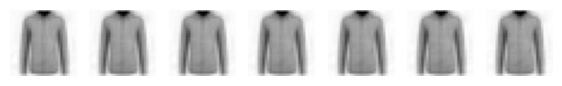

In [ ]:
images = variational_decoder(codings).numpy()
plot_multiple_images(images)
plt.show()